In [118]:
"""
TODO:
The goal here will be to follow the umap tutorial for clustering.
Patrick sent me a sklearn UMAP tutorial (https://umap.scikit-tda.org/basic_usage.html), but it doesn't mention PCA anywhere 
Meanwhile, Haowen sent me another tutorial that also uses sklearn, but explictly has you generate principle components then pass them into UMAP.
Approach:
- follow the mnist tutorial sent by Haowen and see how data is transforned and what the PC file looks like that is sent to sklearn's UMAP
- Transform out .sscore files to match what needs to be sent to sklearn UMAP
- do the transformation, and send the 10 PCs per LG into sklearn UMAP
"""
from sklearn.datasets import fetch_openml # conda install -c anaconda scikit-learn
from sklearn.decomposition import PCA
import numpy as np # comes with sklearn
import pandas as pd
import matplotlib.pyplot as plt # python -m pip install -U matplotlib
import plotly.express as px
import plotly.graph_objs as go
%matplotlib inline


# Dimension reduction and clustering libraries
import umap # conda install -c conda-forge umap-learn
import hdbscan # conda install -c conda-forge hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [54]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)
print(len(mnist.data))

70000


/Users/kmnike/miniforge3/envs/umap/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


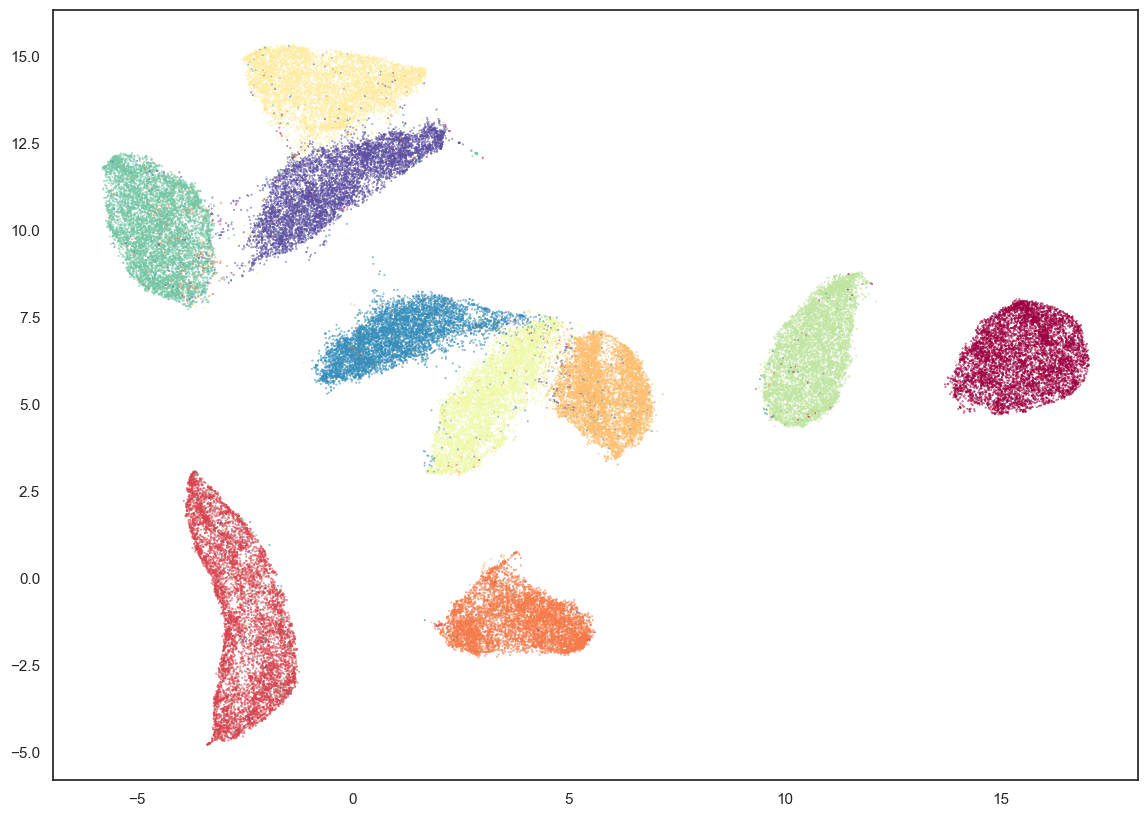

In [55]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');


In [56]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(mnist.data)

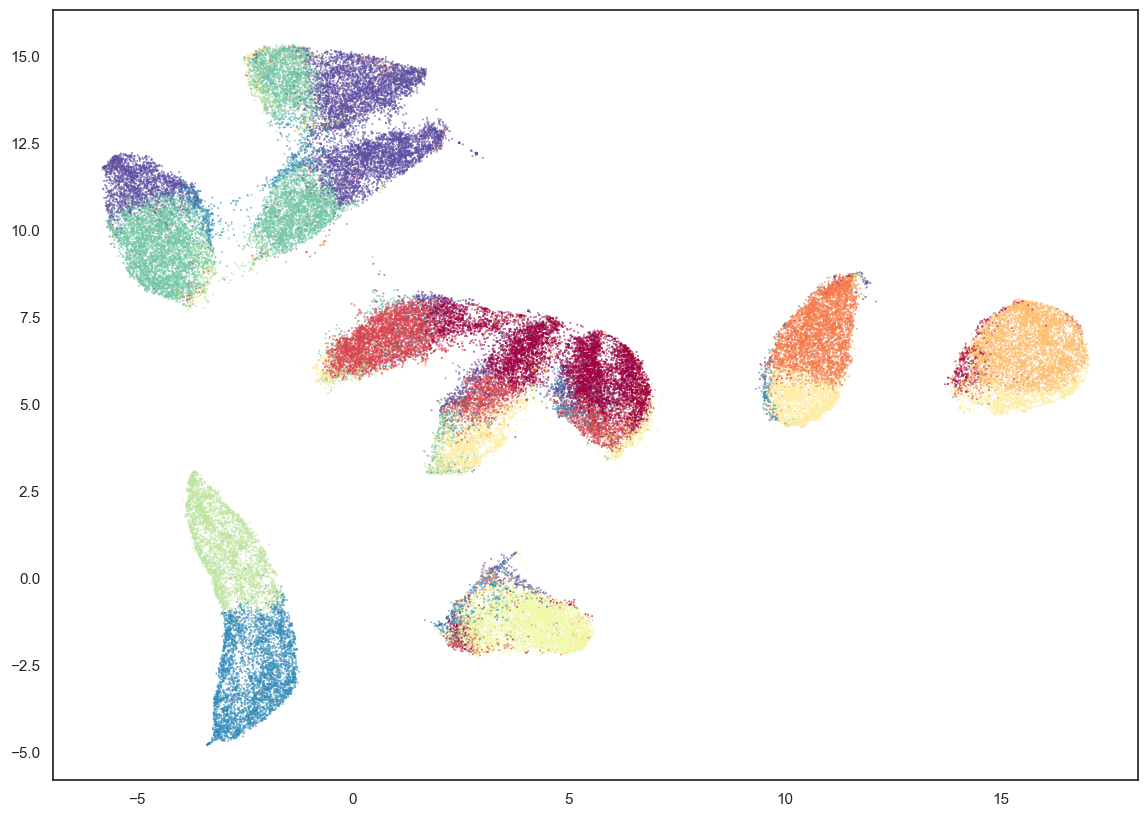

In [57]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [58]:
(
    adjusted_rand_score(mnist.target, kmeans_labels),
    adjusted_mutual_info_score(mnist.target, kmeans_labels)
)

(0.364458609114596, 0.49892688150034564)

In [59]:
lowd_mnist = PCA(n_components=50).fit_transform(mnist.data)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

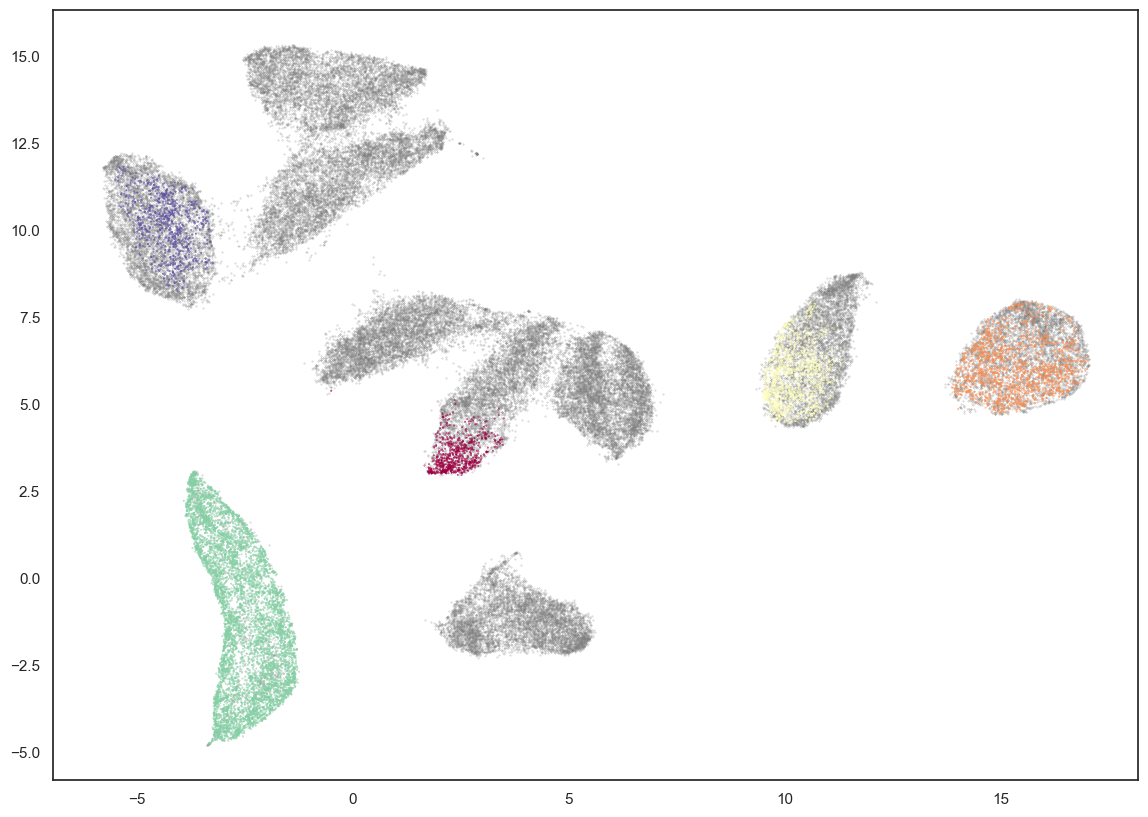

In [60]:
clustered = (hdbscan_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [61]:
(adjusted_rand_score(mnist.target, hdbscan_labels),
 adjusted_mutual_info_score(mnist.target, hdbscan_labels))

(0.054270460220193606, 0.30912670602872516)

In [62]:
clustered = (hdbscan_labels >= 0)
(adjusted_rand_score(mnist.target[clustered], hdbscan_labels[clustered]), 
 adjusted_mutual_info_score(mnist.target[clustered], hdbscan_labels[clustered]))

(0.9984565943346432, 0.9957145907979985)

In [63]:
np.sum(clustered) / mnist.data.shape[0]

0.1725142857142857

In [64]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(mnist.data)

/Users/kmnike/miniforge3/envs/umap/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


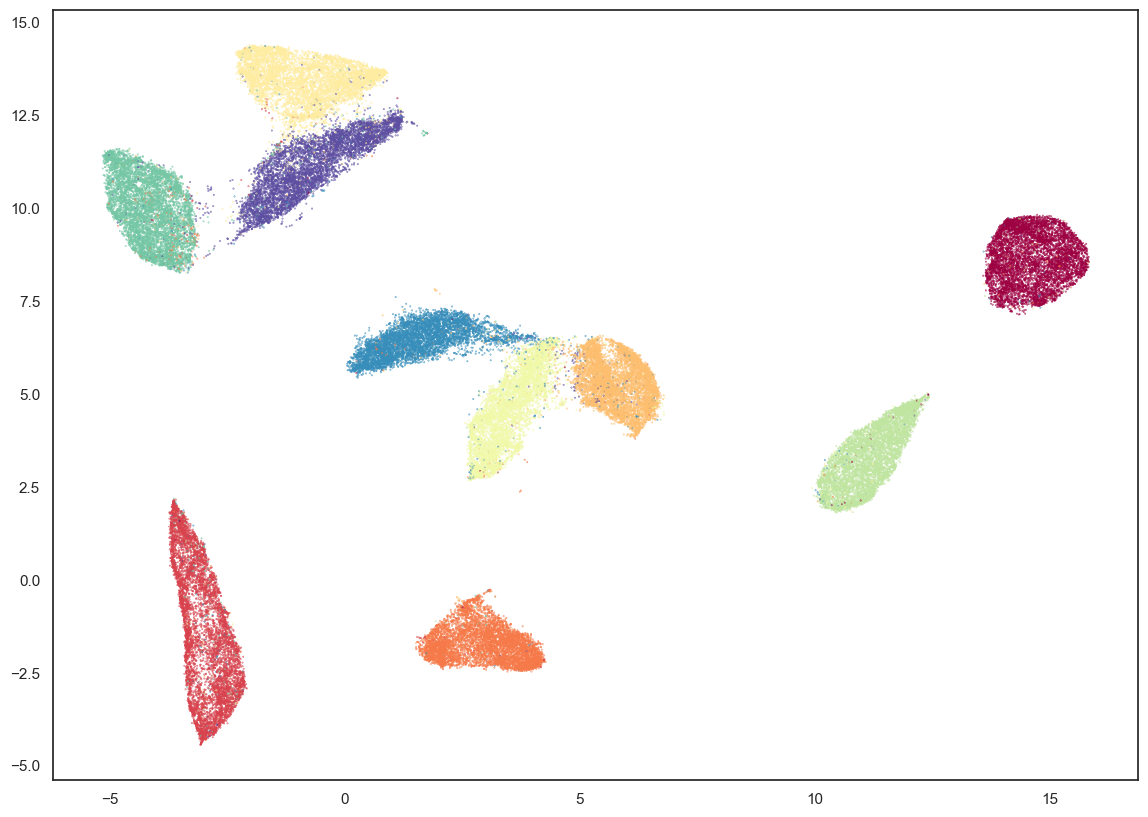

In [65]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=mnist.target, s=0.1, cmap='Spectral');

In [66]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

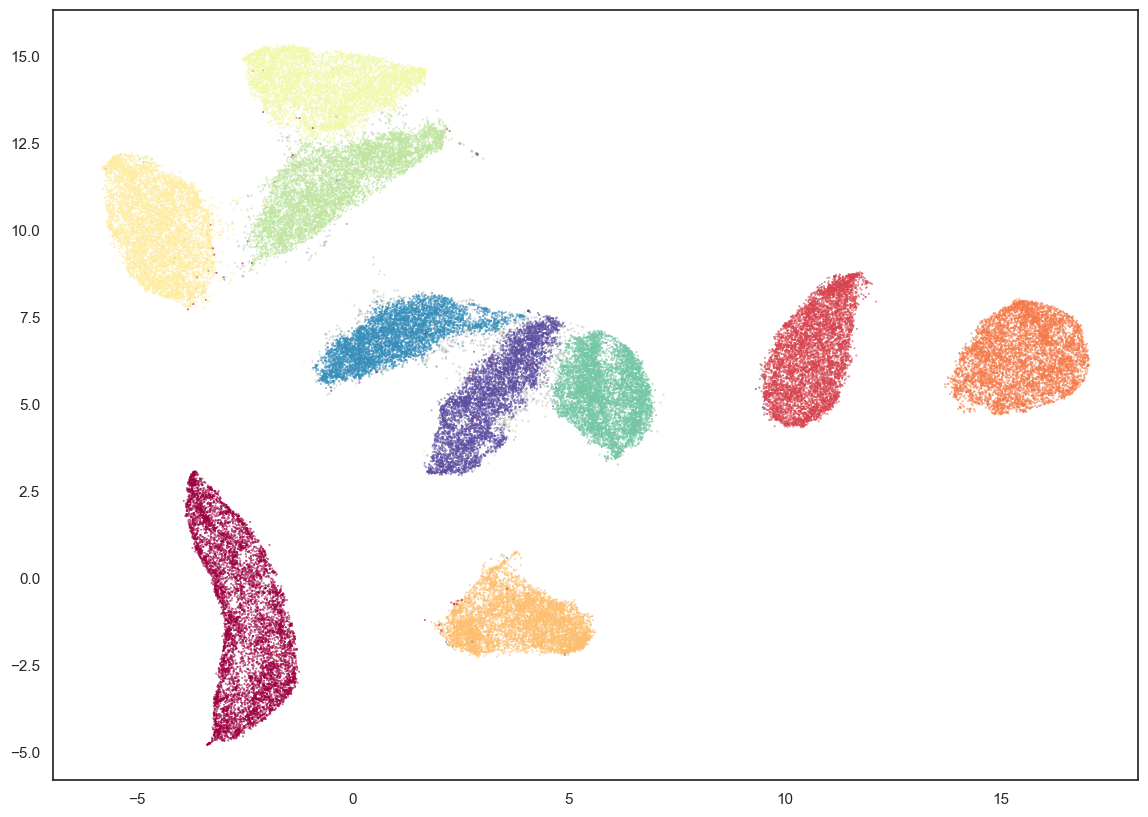

In [67]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [68]:
adjusted_rand_score(mnist.target, labels), adjusted_mutual_info_score(mnist.target, labels)

(0.9193363668612444, 0.9049132845986704)

In [69]:
clustered = (labels >= 0)
(
    adjusted_rand_score(mnist.target[clustered], labels[clustered]),
    adjusted_mutual_info_score(mnist.target[clustered], labels[clustered])
)

(0.9332675787639817, 0.9205762765155171)

In [70]:
np.sum(clustered) / mnist.data.shape[0]

0.9861

In [71]:
test = umap.UMAP()

In [72]:
np.random.seed(42)
data = np.random.rand(800, 4)

In [99]:
data
data.shape

(800, 4)

In [113]:
fit = umap.UMAP()
%time u = fit.fit_transform(data)

CPU times: user 5.87 s, sys: 2.5 s, total: 8.37 s
Wall time: 1.54 s


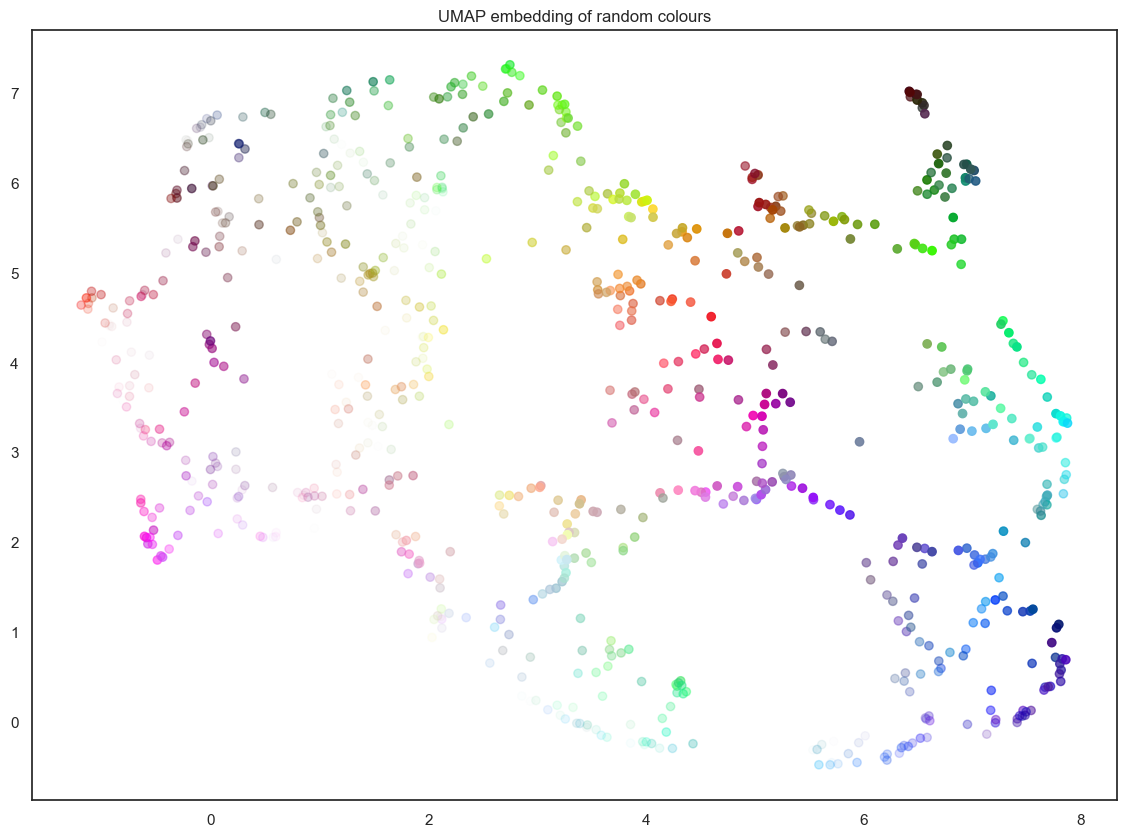

In [114]:
plt.scatter(u[:,0], u[:,1], c=data)
plt.title('UMAP embedding of random colours');

In [151]:
# code to generate and merge the sampledatabase_df and the eigen_df
s_df = pd.read_csv('SampleDatabase.csv')
s_df = s_df[s_df['Platform'].isin(['ILLUMINA'])].drop_duplicates(subset='SampleID')
eigen_df = pd.read_csv('NC_036787.1_new_projection.sscore', sep='\t')
eigen_df = eigen_df.rename(columns = {'#IID':'SampleID'})
df_merged = pd.merge(eigen_df, s_df, on=['SampleID'])
eigen_df
ten_pcs = eigen_df.drop(['SampleID', 'ALLELE_CT', 'NAMED_ALLELE_DOSAGE_SUM'], axis=1)
ten_pcs_np_array = ten_pcs.to_numpy()

# code to use the 10PCs to generate 2 columns of transformed data
fit = umap.UMAP()
umap_transformed_data = fit.fit_transform(ten_pcs_np_array)

# Plotly Code
color_map = {'Mbuna': 'purple', 'AC': 'limegreen', 'Shallow_Benthic': 'red', 'Deep_Benthic': 'blue', 'Rhamphochromis': 'brown', 'Diplotaxodon': 'orange', 'Utaka': 'darkgreen', 'Riverine': 'pink'}
shape_map = {'MalinskyData': 'square', 'Streelman_McGrathData': 'diamond', 'BrainDiversity_s1': 'star', 'MC_males': 'circle', 'MC_females': 'circle-open'}
fig = px.scatter(df_merged, x=umap_transformed_data[:,0], y=umap_transformed_data[:,1], color='Ecogroup', symbol='ProjectID_2', color_discrete_map=color_map, symbol_map=shape_map, title='test_sand_lg8', hover_data=['SampleID', 'Ecogroup', 'Organism', 'ProjectID_2'])
larger_size = 9
smaller_size = 3
fig.update_traces(marker=dict(size=smaller_size), selector=dict(marker_symbol='square'))
fig.update_traces(marker=dict(size=smaller_size), selector=dict(marker_symbol='diamond'))
fig.update_traces(marker=dict(size=larger_size), selector=dict(marker_symbol='circle'))
fig.update_traces(marker=dict(size=larger_size), selector=dict(marker_symbol='circle-open'))
fig.update_traces(marker=dict(size=larger_size), selector=dict(marker_symbol='star'))

fig.write_html('test_umap_plotlyPCA.html')

# fig.show()

